# Assignment 2: Implementing and Comparing RNN & LSTM on MNIST

In this assignment, you will:

1. **Review** how a simple Recurrent Neural Network (RNN) processes sequential data.
2. **Implement** both an RNN and an LSTM from scratch (using NumPy), and train each model on the MNIST dataset.
3. **Compare** their training performance and final accuracy using plots of losses, accuracies, and confusion matrices.

**Key Skills:**
- Defining a basic RNN and LSTM architecture in Python
- Backpropagation through time for parameter updates
- Using the MNIST dataset for image based classification in a sequential setting
- Visualizing and analyzing results using performance curves and confusion matrices

Feel free to experiment with:
- Changing hyperparameters (learning rate, hidden dimension, etc.)
- Different subsets of the training data
- Additional analysis of misclassifications

Your goal is to observe how LSTMs address the limitations of RNNs (particularly vanishing gradients) and potentially achieve better performance on longer sequences.





In [1]:
# ========================================
# Imports and Global Setup
# ========================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics
import seaborn as sns
import random

def set_seed(seed=27):
    '''
    Sets the seed for this assignment so results
    are the same every time we run.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [2]:
# ========================================
# helper functions
# ========================================
# Contains utility functions for analyzing and plotting results.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_confusion_matrix(model, x_test, y_test):
    """
    Generate a confusion matrix for the given model and test data.

    Args:
        model: The trained RNN or LSTM model
        x_test: Test images
        y_test: Test labels

    Returns:
        confusion_matrix: A 10x10 confusion matrix
    """
    predictions = []
    actual_labels = []

    # Get predictions for all test samples
    for i in range(len(x_test)):
        # Forward pass
        outputs, _ = model.forward(x_test[i])

        # Get predicted class
        pred_class = np.argmax(outputs)

        # Store prediction and actual label
        predictions.append(pred_class)
        actual_labels.append(y_test[i])

    # Generate confusion matrix
    conf_matrix = confusion_matrix(actual_labels, predictions, labels=range(10))

    return conf_matrix

def analyze_confusion_matrix(conf_matrix, model_name):
    """
    Print analysis of the confusion matrix

    Args:
        conf_matrix: The confusion matrix to analyze
        model_name: Name of the model (for reporting)
    """
    # Calculate per-class accuracy
    class_accuracy = np.zeros(10)
    for i in range(10):
        class_accuracy[i] = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) * 100

    # Find the classes with highest and lowest accuracy
    best_class = np.argmax(class_accuracy)
    worst_class = np.argmin(class_accuracy)

    print(f"\n{model_name} Confusion Matrix Analysis:")
    print(f"Best recognized digit: {best_class} with {class_accuracy[best_class]:.2f}% accuracy")
    print(f"Worst recognized digit: {worst_class} with {class_accuracy[worst_class]:.2f}% accuracy")

    # Find common misclassifications
    misclassifications = []
    for i in range(10):
        for j in range(10):
            if i != j and conf_matrix[i, j] > 0:
                misclassifications.append((i, j, conf_matrix[i, j]))

    # Sort by number of occurrences
    misclassifications.sort(key=lambda x: x[2], reverse=True)

    print("\nTop 3 misclassifications:")
    for i in range(min(3, len(misclassifications))):
        print(f"  {misclassifications[i][0]} confused as {misclassifications[i][1]}: {misclassifications[i][2]} times")

def plot_confusion_matrices(rnn_model, lstm_model, x_test, y_test):
    """
    Create and save confusion matrix plots for both RNN and LSTM models

    Args:
        rnn_model: Trained RNN model
        lstm_model: Trained LSTM model
        x_test: Test data features
        y_test: Test data labels
    """
    # Create a figure with two subplots side by side
    plt.figure(figsize=(20, 8))

    # RNN confusion matrix
    plt.subplot(1, 2, 1)
    rnn_conf_matrix = get_confusion_matrix(rnn_model, x_test, y_test)
    sns.heatmap(rnn_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix: RNN', fontsize=15)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # LSTM confusion matrix
    plt.subplot(1, 2, 2)
    lstm_conf_matrix = get_confusion_matrix(lstm_model, x_test, y_test)
    sns.heatmap(lstm_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix: LSTM', fontsize=15)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    print("Confusion matrices saved to 'confusion_matrices.png'")

    # Print analysis
    analyze_confusion_matrix(rnn_conf_matrix, "RNN")
    analyze_confusion_matrix(lstm_conf_matrix, "LSTM")

    return rnn_conf_matrix, lstm_conf_matrix

def plot_performance_curves(rnn_results, lstm_results):
    """
    Create and save plots of training and testing metrics

    Args:
        rnn_results: Dictionary containing RNN training results
        lstm_results: Dictionary containing LSTM training results
    """
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(rnn_results['train_losses'], label='RNN Training Loss')
    plt.plot(lstm_results['train_losses'], label='LSTM Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(rnn_results['test_losses'], label='RNN Test Loss')
    plt.plot(lstm_results['test_losses'], label='LSTM Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(rnn_results['train_accuracies'], label='RNN Training Accuracy')
    plt.plot(lstm_results['train_accuracies'], label='LSTM Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(rnn_results['test_accuracies'], label='RNN Test Accuracy')
    plt.plot(lstm_results['test_accuracies'], label='LSTM Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_comparison_plots.png')
    print("Performance plots saved to 'model_comparison_plots.png'")


def rel_error(x, y, eps=1e-10):
    """Return maximum relative error between x and y."""
    return np.max(np.abs(x - y) / np.maximum(eps, np.abs(x) + np.abs(y)))

def eval_numerical_gradient_array(f, x, df=1.0, h=1e-5):
    """
    Numerical gradient of f w.r.t x.
    Assumes x is a numpy array and f(x) returns a scalar.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        old_val = x[idx]

        # f(x + h)
        x[idx] = old_val + h
        fxph = f(x)
        # f(x - h)
        x[idx] = old_val - h
        fxmh = f(x)

        grad[idx] = (fxph - fxmh) / (2 * h)
        x[idx] = old_val  # restore
        it.iternext()
    return grad


From Now, we will walk through:

1. Basic RNN concepts  
2. Implementing a simple RNN class  
3. Applying an RNN to the MNIST dataset  
4. Comparing RNN vs. LSTM for performance  

**Your task** is to fill in any `# TODO` parts and experiment with different hyperparameters, data subsets, and analysis. ***Two points per `# TODO`***


#Simple RNN (Single Layer)
**Recurrent Neural Networks** (RNNs) differ from classic **feed forward networks** (FNNs) or **convolutional networks** (CNNs) in how they handle sequence data. Instead of processing each input independently, they maintain a hidden state that carries information from previous time steps.

Key points about a 1-layer RNN:

1. The network can use previous information to affect the current output.
2. It has three conceptual parts: an Input layer, a Hidden state, and an Output layer.
3. It processes each element (time step) in a sequence, carrying forward the hidden state.
4. The hidden state is updated at each time step via learnable matrices – typically noted (in some references) as U for input, W for hidden recurrent connections, and V for output. In our code, they appear slightly differently.
5. Because these weight matrices are reused for all time steps, an RNN can (in theory) handle sequences of arbitrary length.


Here’s a common diagram of an RNN unrolled over time:

<img src="https://i.imgur.com/RW41Wqj.png" width="600">

obtained from https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99

In [3]:
# ===========================
# Single-Layer RNN
# ===========================
import numpy as np

class RNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        TODO 1:
          - Initialize RNN parameters with the correct shapes.
          - self.input_dim, self.hidden_dim, self.output_dim are given.
          - Hint: The scale factor is 0.1, for example.
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # TODO 1.1: Weight initialization
        self.Wh = np.random.randn(hidden_dim, hidden_dim) * 0.1  # Recurrent weights
        self.Wx = np.random.randn(hidden_dim, input_dim) * 0.1  # Input weights
        self.Wy = np.random.randn(output_dim, hidden_dim) * 0.1  # Output weights

        # TODO 1.2: Bias initialization (zeros)
        self.bh = np.zeros((hidden_dim, 1))  # Bias for hidden state
        self.by = np.zeros((output_dim, 1))  # Bias for outputpass 

    def tanh(self, x):
        """
        TODO 2: Implement tanh for the RNN
        """
        # TODO 2.1 Return Tanh function
        return np.tanh(x)

    def forward(self, X):
        """
        TODO 3: Forward pass for the RNN.

        Args:
          X shape: (sequence_length, input_dim)
          e.g. For a flattened row of 28 pixels, sequence_length=28, input_dim=28
        Returns:
          y: final output
          h_t: final hidden state
        """
        
        # TODO 3.1 Initialize hidden state
        h_t = np.zeros((self.hidden_dim, 1))  # Initialize hidden state
        h_prev = h_t # Keep track of the previous hidden state

        # 3.2 Cache
        self.cache = []

        # TODO 3.3 Process each time step
        for t in range(X.shape[0]):
            x_t = X[t].reshape(-1, 1)  # Convert input row to column vector
            h_t = self.tanh(np.dot(self.Wh, h_prev) + np.dot(self.Wx, x_t) + self.bh)  # Update hidden state
            self.cache.append((h_prev, x_t, h_t))  # Store for backprop
            h_prev = h_t
        # TODO 3.4 Final output after last time step
        y = np.dot(self.Wy, h_t) + self.by  # Final output

        return y, h_t

    def backward(self, dLdy, learning_rate=0.001, clip_value=5.0):
        """
        TODO 4: Backpropagation through time (BPTT).

        dLdy: gradient of the loss w.r.t. final output
        learning_rate: step size for updates
        clip_value: gradient clipping threshold
        """
        # 4.1 Initialize partial derivatives
        dWh = np.zeros_like(self.Wh)
        dWx = np.zeros_like(self.Wx)
        dWy = np.zeros_like(self.Wy)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)

        # 4.2 Make sure dLdy has correct shape
        dLdy = dLdy.reshape(self.by.shape)

        # TODO 4.3 Gradient of final output
        h_last = self.cache[-1][2]

        # The last hidden state is stored in self.cache[-1][2]
        # dWy = np.dot(dLdy, self.cache[-1][2].T)

        dWy += np.dot(dLdy, h_last.T)
        dby = dLdy  # dL/dby

        # TODO 4.4 Flow back to hidden
        dh_next = np.dot(self.Wy.T, dLdy)  # Backprop to hidden state

        # 4.5 Loop backward over time
        for t in reversed(range(len(self.cache))):
            h_prev, x_t, h_t = self.cache[t]

            # TODO
            # gradient of tanh
            dtanh = (1 - h_t ** 2) * dh_next  # Derivative of tanh
            # update weights and bias
            dWh += np.dot(dtanh, h_prev.T)
            dWx += np.dot(dtanh, x_t.T)
            dbh += dtanh

            if t > 0:
                # hidden state from previous time step
                dh_next = np.dot(self.Wh.T, dtanh)  # Pass gradient back
            else:
                dh_next = np.zeros_like(h_prev)  # Stop when reaching the first timestep

        # 4.6 Clip gradients to avoid exploding
        for grad in [dWh, dWx, dWy, dbh, dby]:
            np.clip(grad, -clip_value, clip_value, out=grad)

        # 4.7 Update parameters
        self.Wh -= learning_rate * dWh
        self.Wx -= learning_rate * dWx
        self.Wy -= learning_rate * dWy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby

In [4]:
def test_rnn_shapes_and_grad(rnn_class):
    """
    Tests:
      (A) shape checks for forward pass
      (B) numerical gradient check w.r.t. RNN parameters
          OR w.r.t input, if your RNN code supports that
    """

    print("========== Test RNN layer ==========")

    # (1) Create a small random input X with shape (time_steps, input_dim)
    time_steps = 3
    input_dim = 4
    hidden_dim = 5
    output_dim = 2

    # For reproducibility
    np.random.seed(27)

    # Instantiate the RNN
    model = rnn_class(input_dim, hidden_dim, output_dim)

    # Create random input
    X = np.random.randn(time_steps, input_dim)
    # Forward pass
    y, h_final = model.forward(X)

    # =============================
    # (A) SHAPE CHECK
    # =============================
    # The final output y should have shape (output_dim, 1)
    # The final hidden state h_final should have shape (hidden_dim, 1)
    print("Forward output y shape:", y.shape, f"(expected {(output_dim, 1)})")
    print("Final hidden shape:", h_final.shape, f"(expected {(hidden_dim, 1)})")

test_rnn_shapes_and_grad(RNN)

========== Test RNN layer ==========
Forward output y shape: (2, 1) (expected (2, 1))
Final hidden shape: (5, 1) (expected (5, 1))


## From Basic RNN to LSTM

### 1. Why RNNs Struggle on Long Sequences

A **Recurrent Neural Network (RNN)** maintains a hidden state \\(\\bf{h}\\) that evolves over time, combining the new input \\(\\bf{x}_t\\) with the previous state \\(\\bf{h}_{t-1}\\). This approach helps RNNs handle sequential data, but they often suffer from **vanishing (or exploding) gradients** when sequences become long.

**Vanishing gradients** happen because, during **backpropagation through time (BPTT)**, gradients get multiplied repeatedly by the recurrent weight matrix at each time step. If those weights are small, the gradients can shrink exponentially as you go backward through many timesteps. This often prevents the network from “remembering” early inputs in a long sequence.


### 2. LSTM’s Key Idea

A **Long Short-Term Memory (LSTM)** network addresses the vanishing gradient problem by introducing a **cell state** \(\mathbf{c}_t\) and a set of **gates** that carefully control the flow of information:

1. **Forget Gate** \\(\\b{f}_t\\): Decides what information to **discard** from the cell state.
2. **Input Gate** \\(\\b{i}_t\\): Decides what new information to **add** to the cell state via a candidate \\(\\bf{c}_t^\sim\\).
3. **Cell State** \\(\\b{c}_t\\): Combines the previous state with the newly scaled candidate.
4. **Output Gate** \\(\\b{o}_t\\): Decides what the **hidden state** \\(\\b{h}_t\\) should be, based on the updated cell state.

By selectively forgetting or adding information, LSTM units can preserve important signals for longer, thus **significantly reducing** the problem of vanishing gradients.

### 3. Comparing RNN vs. LSTM

| Aspect                | Basic RNN                                          | LSTM                                                                  |
|-----------------------|----------------------------------------------------|-----------------------------------------------------------------------|
| **Hidden State**      | Single hidden state \\(\\b{h}_t\\) only          | Hidden state \\(\\b{h}_t\\) **plus** cell state \\(\\b{c}_t\\)     |
| **Memory Mechanism**  | Relies on repeated matrix multiplication           | Uses gating (input, forget, output) to control memory more precisely  |
| **Vanishing Gradient**| Likely for long sequences                          | Much less likely, due to explicit cell state and gating               |
| **Performance**       | Often good for short or modest sequence lengths    | Typically superior for longer sequences or tasks needing longer memory |

### 4. Inside an LSTM Step

In code, each time step uses:

\[
\begin{aligned}
\mathbf{i}_t &= \sigma(W_i \mathbf{x}_t + U_i \mathbf{h}_{t-1} + \mathbf{b}_i), \\
\mathbf{f}_t &= \sigma(W_f \mathbf{x}_t + U_f \mathbf{h}_{t-1} + \mathbf{b}_f), \\
\mathbf{o}_t &= \sigma(W_o \mathbf{x}_t + U_o \mathbf{h}_{t-1} + \mathbf{b}_o), \\
\tilde{\mathbf{c}}_t &= \tanh(W_c \mathbf{x}_t + U_c \mathbf{h}_{t-1} + \mathbf{b}_c), \\
\mathbf{c}_t &= \mathbf{f}_t \odot \mathbf{c}_{t-1} \;+\; \mathbf{i}_t \odot \tilde{\mathbf{c}}_t, \\
\mathbf{h}_t &= \mathbf{o}_t \odot \tanh(\mathbf{c}_t).
\end{aligned}
\]

- **\\(\\b{f}_t\\)** (forget gate) decides what fraction of \\(\\b{c}_{t-1}\\) to keep.  
- **\\(\\b{i}_t\\)** (input gate) decides how much of the new candidate \\(\\tilde{\mathbf{c}}_t\\) to add in.  
- **\\(\\b{c}_t\\)** (cell state) becomes the new “long-term memory.”  
- **\\(\\b{o}_t\\)** (output gate) scales the final hidden state.  

### 5. Why LSTM Helps

Because the LSTM cell state \(\mathbf{c}_t\) can carry gradients more directly back through time, the model can retain important signals from earlier timesteps—rather than exponentially shrinking them. This gating mechanism makes LSTMs especially powerful for tasks such as language modeling, speech recognition, or any problem where a network must “remember” relevant context over many steps.

### 6. Code Overview (Student TODO)

In the `LSTM.py - Student TODO Version`, we see:

1. **Initialization**: We create separate weight matrices (`Wi`, `Ui`, `Wf`, etc.) for each gate, plus a final `Wy` for outputs.
2. **Forward**: We loop over timesteps, computing each gate, updating \\(\\b{c}_t\\), then deriving \\(\\b{h}_t\\). We store these values in `self.cache` for backpropagation.
3. **Backward**: We perform BPTT in reverse, using the chain rule to update each gate’s parameters. We also handle **gradient clipping** to avoid exploding gradients.
4. **Comparison to RNN**: While an RNN also keeps a hidden state \\(\\b{h}_t\\), it lacks the cell state \\(\\b{c}_t\\) or gating. This means an RNN might quickly forget early inputs in a long sequence. The LSTM, through gating, selectively maintains or discards information, typically leading to better performance on longer tasks.

**TL;DR**: LSTM is effectively a more advanced RNN that uses an internal gating mechanism to address vanishing gradients and remember information for longer sequences.


In [5]:
# ========================================
# LSTM
# ========================================
import numpy as np

class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        TODO 1:
            - Initialize LSTM parameters with correct shapes.
            - Use a scale factor for random initialization (e.g., scale=0.1).
            - The parameters you need are:
                Wi, Ui, bi  -> for the input gate
                Wf, Uf, bf  -> for the forget gate
                Wo, Uo, bo  -> for the output gate
                Wc, Uc, bc  -> for the cell state (candidate)
                Wy, by      -> for the final output layer
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # 1.1: Scale
        scale = 0.1

        # TODO 1.2 Initialize Input gate
        self.Wi = np.random.randn(hidden_dim, input_dim) * scale
        self.Ui = np.random.randn(hidden_dim, hidden_dim) * scale
        self.bi = np.zeros((hidden_dim, 1))


        # TODO 1.3 Initialize Forget gate
        self.Wf = np.random.randn(hidden_dim, input_dim) * scale
        self.Uf = np.random.randn(hidden_dim, hidden_dim) * scale
        self.bf = np.zeros((hidden_dim, 1))

        # TODO 1.4 Initialize Output gate
        self.Wo = np.random.randn(hidden_dim, input_dim) * scale
        self.Uo = np.random.randn(hidden_dim, hidden_dim) * scale
        self.bo = np.zeros((hidden_dim, 1))

        # TODO 1.5 Initialize Cell
        self.Wc = np.random.randn(hidden_dim, input_dim) * scale
        self.Uc = np.random.randn(hidden_dim, hidden_dim) * scale
        self.bc = np.zeros((hidden_dim, 1))

        # TODO 1.6 Initialize Final output layer
        self.Wy = np.random.randn(output_dim, hidden_dim) * scale
        self.by = np.zeros((output_dim, 1))

    def sigmoid(self, x):
        """
        TODO 2: Implement sigmoid in a safe manner, e.g. clipping x
                (already done partially with np.clip).
        """
        # TODO 2.1 Return Sigmoid Function
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def tanh(self, x):
        """
        TODO 3: Implement or use np.tanh for the LSTM cell candidate & output gating.
        """
        # TODO 3.1 Return Tanh Function
        return np.tanh(x)

    def forward(self, X):
        """
        TODO 4: Forward pass through the LSTM.

        X shape: (sequence_length, input_dim)
        We'll maintain hidden state (h_prev) and cell state (c_prev),
        then compute i_t, f_t, o_t, c_tilde, c_t, h_t for each time step.

        Save necessary values in self.cache for BPTT.
        Return:
          y (final output), shape = (output_dim, 1)
          h_t (final hidden state), shape = (hidden_dim, 1)
        """
        # TODO 4.1 : Initialize previous hidden state and previous cell state
        h_prev = np.zeros((self.hidden_dim, 1))
        c_prev = np.zeros((self.hidden_dim, 1))

        # 4.2 Cache
        self.cache = []

        # TODO 3.3 Process each time step
        for t in range(X.shape[0]):
            # Reshape the input row into a column
            x_t = X[t].reshape(-1, 1)

            # TODO 3.4 Implement Input gate
            i_t = self.sigmoid(np.dot(self.Wi, x_t) + np.dot(self.Ui, h_prev) + self.bi)

            # TODO 3.5 Implement Forget gate
            f_t = self.sigmoid(np.dot(self.Wf, x_t) + np.dot(self.Uf, h_prev) + self.bf)

            # TODO 3.6 Implement Output gate
            o_t = self.sigmoid(np.dot(self.Wo, x_t) + np.dot(self.Uo, h_prev) + self.bo)

            # TODO 3.7 Implement Candidate
            c_tilde = self.tanh(np.dot(self.Wc, x_t) + np.dot(self.Uc, h_prev) + self.bc)

            # TODO 3.8 Compute C and H
            c_t = f_t * c_prev + i_t * c_tilde
            h_t = o_t * self.tanh(c_t)


            # Append to cache for backprop
            self.cache.append((h_prev, x_t, i_t, f_t, o_t, c_tilde, c_prev, c_t, h_t))
            # Move forward in time
            h_prev = h_t
            c_prev = c_t

        # TODO 3.9 Final output after last time step
        y = np.dot(self.Wy, h_t) + self.by
        return y, h_t

    def backward(self, dLdy, learning_rate=0.001, clip_value=5.0):
        """
        TODO 5: Backpropagation for LSTM

        dLdy: gradient of loss w.r.t. final output
        Steps:
          1) compute gradient for final output layer (Wy, by)
          2) iterate backward over each time step to get i_t, f_t, o_t, c_tilde, etc.
          3) clip the gradients
          4) update parameters
        """
        # 5.1 Initialize param grads
        dWi, dUi, dbi = np.zeros_like(self.Wi), np.zeros_like(self.Ui), np.zeros_like(self.bi)
        dWf, dUf, dbf = np.zeros_like(self.Wf), np.zeros_like(self.Uf), np.zeros_like(self.bf)
        dWo, dUo, dbo = np.zeros_like(self.Wo), np.zeros_like(self.Uo), np.zeros_like(self.bo)
        dWc, dUc, dbc = np.zeros_like(self.Wc), np.zeros_like(self.Uc), np.zeros_like(self.bc)
        dWy, dby = np.zeros_like(self.Wy), np.zeros_like(self.by)

        # 5.2 Reshape dLdy
        dLdy = dLdy.reshape(self.by.shape)

        # TODO 5.3: Compute gradient of final output
        h_last = self.cache[-1][8]
        dWy += np.dot(dLdy, h_last.T)
        dby += dLdy

        # TODO 5.4 Flow back to Next hidden & cell gradients
        dh_next = np.dot(self.Wy.T, dLdy)
        dc_next = np.zeros_like(dh_next)


        # 5.5 Loop backward over time
        for t in reversed(range(len(self.cache))):
            (h_prev, x_t, i_t, f_t, o_t, c_tilde, c_prev, c_t, h_t) = self.cache[t]

            # TODO 5.6 Compute partial derivatives
            do = dh_next * self.tanh(c_t) * o_t * (1 - o_t)
            dc = dh_next * o_t * (1 - self.tanh(c_t)**2) + dc_next
            df = dc * c_prev * f_t * (1 - f_t)
            di = dc * c_tilde * i_t * (1 - i_t)
            dc_tilde = dc * i_t * (1 - c_tilde**2)

            # TODO 5.7 Update the weights and bias
            dWi += np.dot(di, x_t.T)
            dUi += np.dot(di, h_prev.T)
            dbi += di

            dWf += np.dot(df, x_t.T)
            dUf += np.dot(df, h_prev.T)
            dbf += df

            dWo += np.dot(do, x_t.T)
            dUo += np.dot(do, h_prev.T)
            dbo += do

            dWc += np.dot(dc_tilde, x_t.T)
            dUc += np.dot(dc_tilde, h_prev.T)
            dbc += dc_tilde

            # TODO 5.8 Compute dx and dh_prev and dc_prev
            dx = (
                np.dot(self.Wi.T, di) +
                np.dot(self.Wf.T, df) +
                np.dot(self.Wo.T, do) +
                np.dot(self.Wc.T, dc_tilde)
            )

            dh_prev = (
                np.dot(self.Ui.T, di) +
                np.dot(self.Uf.T, df) +
                np.dot(self.Uo.T, do) +
                np.dot(self.Uc.T, dc_tilde)
            )

            dc_prev = dc * f_t

            # TODO 5.9 Move forward in time
            dh_next = dh_prev
            dc_next = dc_prev


        # Clip grads
        for grad in [dWi, dUi, dbi, dWf, dUf, dbf, dWo, dUo, dbo, dWc, dUc, dbc, dWy, dby]:
            np.clip(grad, -clip_value, clip_value, out=grad)

        # 5.10: Update parameters
        self.Wi -= learning_rate * dWi
        self.Ui -= learning_rate * dUi
        self.bi -= learning_rate * dbi

        self.Wf -= learning_rate * dWf
        self.Uf -= learning_rate * dUf
        self.bf -= learning_rate * dbf

        self.Wo -= learning_rate * dWo
        self.Uo -= learning_rate * dUo
        self.bo -= learning_rate * dbo

        self.Wc -= learning_rate * dWc
        self.Uc -= learning_rate * dUc
        self.bc -= learning_rate * dbc

        self.Wy -= learning_rate * dWy
        self.by -= learning_rate * dby

In [6]:
def test_lstm_shapes_and_grad(LSTM_class):
    """
    Tests the student's LSTM class for:
      A) shape correctness in forward pass
      B) optional numerical gradient check for parameters
    """
    print("========== Test LSTM layer ==========")
    np.random.seed(42)

    # 1) Instantiate a small LSTM
    time_steps = 3
    input_dim = 4
    hidden_dim = 5
    output_dim = 2

    model = LSTM_class(input_dim, hidden_dim, output_dim)

    # 2) Create random input
    X = np.random.randn(time_steps, input_dim)

    # 3) Forward pass
    y, h_final = model.forward(X)

    # A) SHAPE CHECK
    print("Forward output y shape:", y.shape, f"(expected {(output_dim, 1)})")
    print("Final hidden state shape:", h_final.shape, f"(expected {(hidden_dim, 1)})")

# Example usage:
# from LSTM import LSTM
test_lstm_shapes_and_grad(LSTM)

========== Test LSTM layer ==========
Forward output y shape: (2, 1) (expected (2, 1))
Final hidden state shape: (5, 1) (expected (5, 1))


In the following, we:

1. **Load and preprocess** the MNIST dataset from Keras, extracting 5,000 samples for training (`x_train_subset`, `y_train_subset`) and 1,000 for testing (`x_test_subset`, `y_test_subset`). We normalize pixel values to the [0, 1] range.

2. **Define the `train_network` function**:
   - Chooses whether to build an `RNN` or an `LSTM` model based on the `model_type` argument.
   - Initializes tracking lists for losses and accuracies (`train_losses`, `test_losses`, etc.).
   - Runs a loop over a fixed number of epochs (`epochs` = 10 by default).
   - Within each epoch:
     - Shuffles the training subset.
     - Processes the data in mini-batches (`batch_size` = 64).
     - For each sample in a batch:
       1. **Forward pass** (`model.forward(...)`)  
       2. **Compute loss** (`MSE` between outputs and one-hot targets)  
       3. **Backward pass** (`model.backward(...)`) and updates parameters  
       4. **Accumulate** train loss and count correct predictions
     - Calculates average train loss and accuracy at the end of each epoch.
     - **Tests** on the subset of 1,000 samples from MNIST, computing test loss and accuracy similarly (without parameter updates).
   - Prints progress during training and summary results at the end.

3. **At the bottom**:
   - Trains and evaluates both an `RNN` and an `LSTM`, printing a final comparison of their test accuracies and training times.
   - Optionally, calls plotting functions for performance curves and confusion matrices (if libraries are available).


x_train shape: (60000, 28, 28)
Training RNN model...
Epoch 1/9, Batch 10, Loss: 0.0739
Epoch 1/9, Batch 20, Loss: 0.0661
Epoch 1/9, Batch 30, Loss: 0.0578
Epoch 1/9, Batch 40, Loss: 0.0558
Epoch 1/9, Batch 50, Loss: 0.0512
Epoch 1/9, Batch 60, Loss: 0.0398
Epoch 1/9, Batch 70, Loss: 0.0574
Epoch 1/9 | Train Loss: 0.0639 | Train Acc: 61.06% | Test Loss: 0.0409 | Test Acc: 77.60%
Epoch 2/9, Batch 10, Loss: 0.0549
Epoch 2/9, Batch 20, Loss: 0.0330
Epoch 2/9, Batch 30, Loss: 0.0434
Epoch 2/9, Batch 40, Loss: 0.0384
Epoch 2/9, Batch 50, Loss: 0.0449
Epoch 2/9, Batch 60, Loss: 0.0229
Epoch 2/9, Batch 70, Loss: 0.0253
Epoch 2/9 | Train Loss: 0.0382 | Train Acc: 81.50% | Test Loss: 0.0390 | Test Acc: 79.80%
Epoch 3/9, Batch 10, Loss: 0.0412
Epoch 3/9, Batch 20, Loss: 0.0276
Epoch 3/9, Batch 30, Loss: 0.0254
Epoch 3/9, Batch 40, Loss: 0.0330
Epoch 3/9, Batch 50, Loss: 0.0279
Epoch 3/9, Batch 60, Loss: 0.0333
Epoch 3/9, Batch 70, Loss: 0.0297
Epoch 3/9 | Train Loss: 0.0285 | Train Acc: 87.44% | 

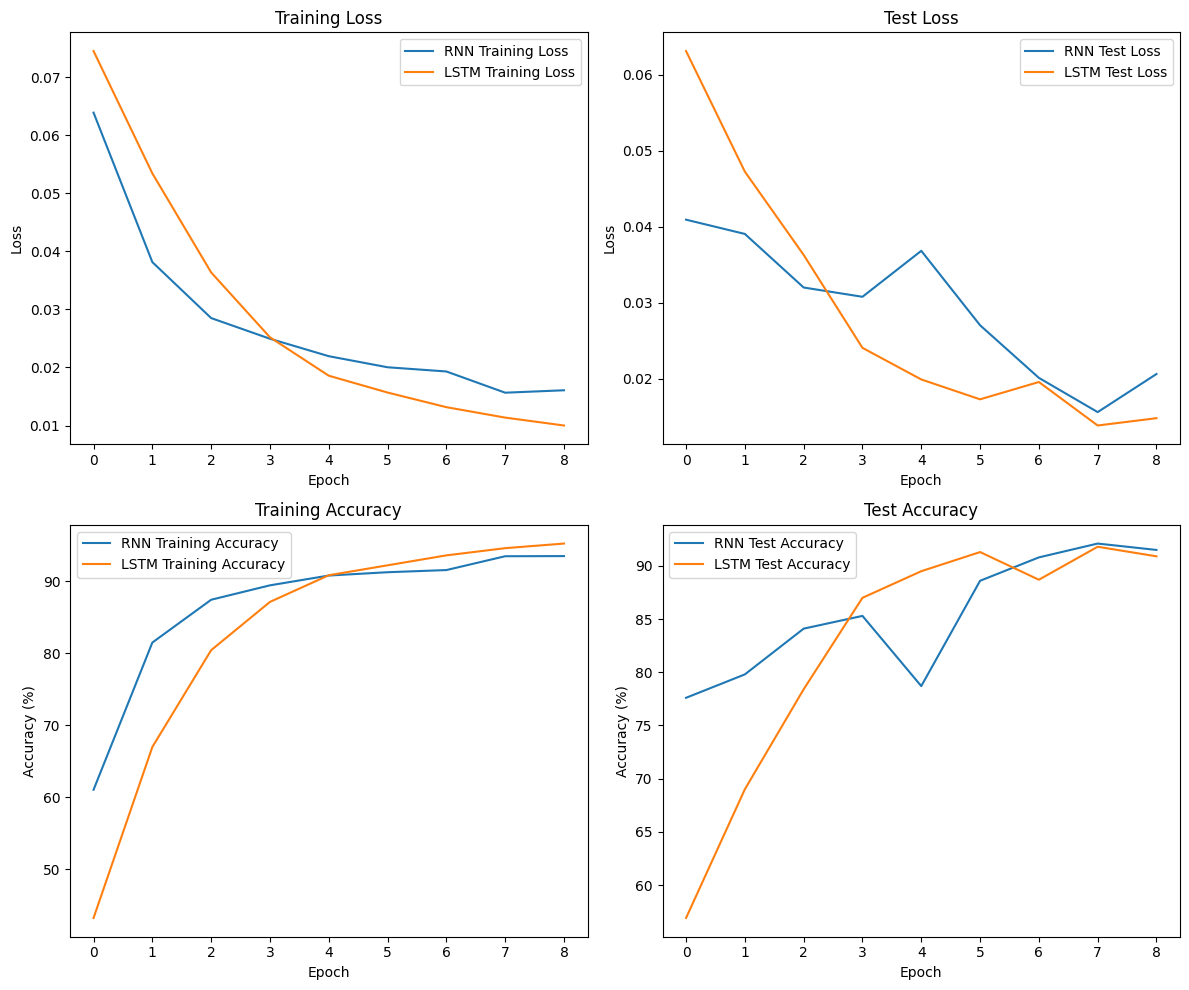

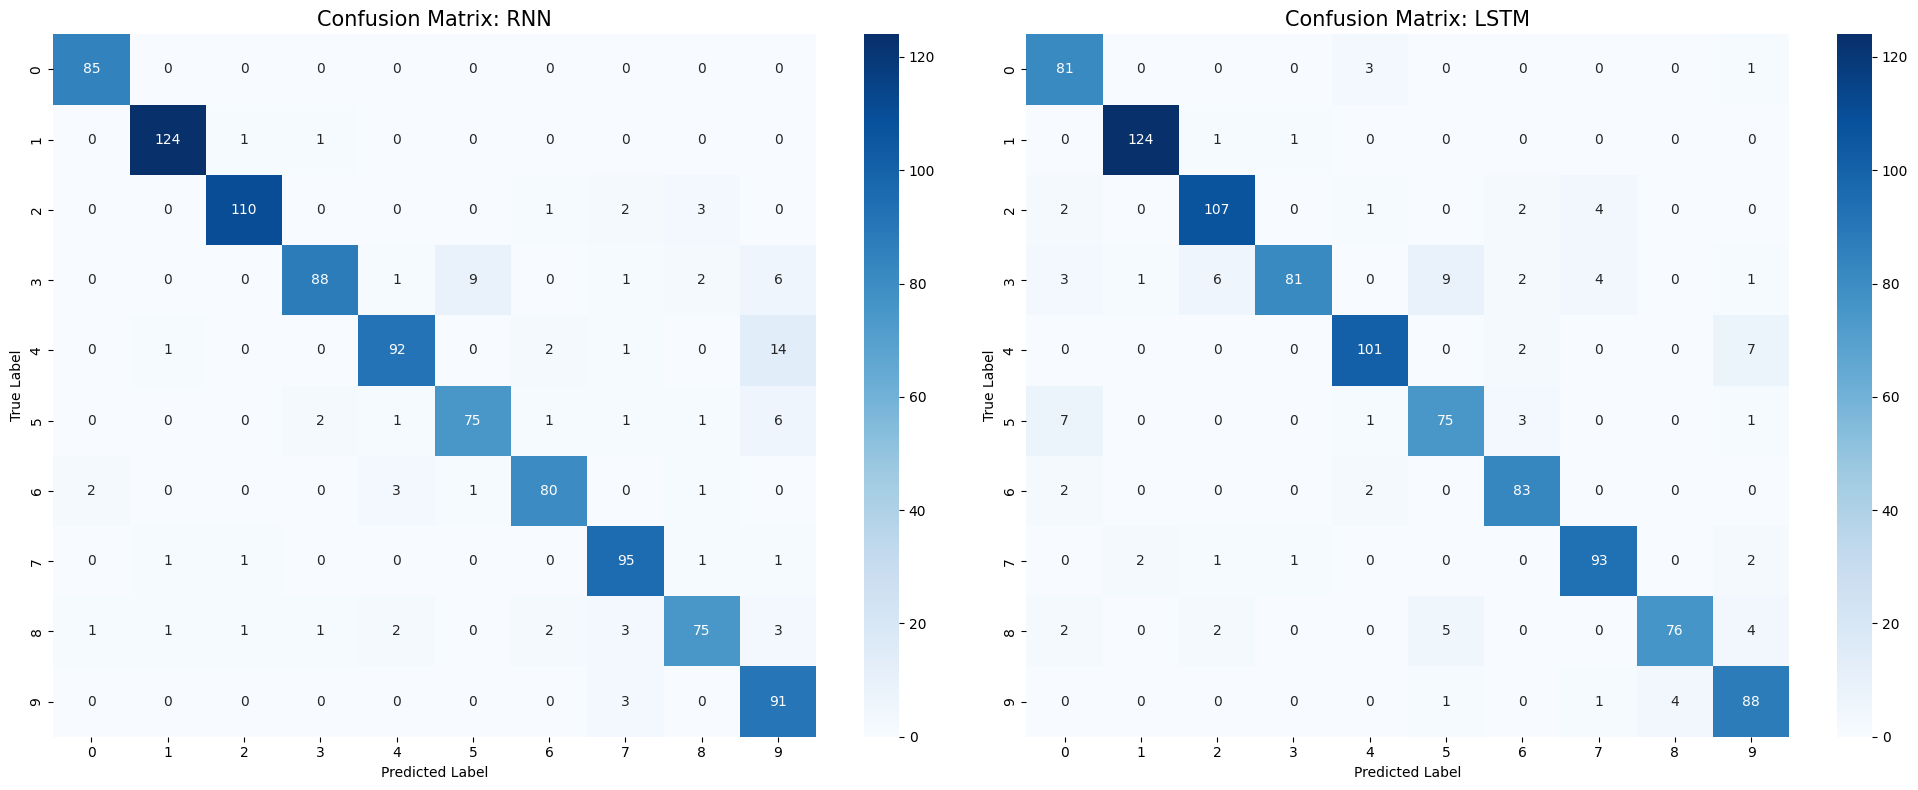

In [7]:
# ========================================
# main
# ========================================
import numpy as np
from keras.datasets import mnist
import time

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"x_train shape: {x_train.shape}")

# Normalize pixel values to [0,1]
x_train = x_train.astype(np.float32) / 255.0
x_test  = x_test.astype(np.float32)  / 255.0

# Hyperparameters
input_dim    = 28
hidden_dim   = 128
output_dim   = 10

# TODO 3: try to use different parameters
learning_rate = 0.005
batch_size    = 64
epochs        = 9

num_train_samples = 5000
num_test_samples  = 1000

x_train_subset = x_train[:num_train_samples]
y_train_subset = y_train[:num_train_samples]
x_test_subset  = x_test[:num_test_samples]
y_test_subset  = y_test[:num_test_samples]

def train_network(model_type='rnn'):
    """
    Trains either an RNN or an LSTM on a subset of MNIST.
    model_type: 'rnn' or 'lstm'
    Returns: dictionary with model & metrics
    """

    # from RNN import RNN
    # from LSTM import LSTM
    # Or assume they are already defined in the environment.

    if model_type.lower() == 'rnn':
        model = RNN(input_dim, hidden_dim, output_dim)
        model_name = "RNN"
    else:
        model = LSTM(input_dim, hidden_dim, output_dim)
        model_name = "LSTM"

    train_losses = []
    test_losses  = []
    train_accuracies = []
    test_accuracies  = []
    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss    = 0.0
        correct_train = 0
        batch_count   = 0

        # Shuffle the training data
        indices     = np.random.permutation(len(x_train_subset))
        x_shuffled  = x_train_subset[indices]
        y_shuffled  = y_train_subset[indices]

        # Go through batches
        for i in range(0, len(x_shuffled), batch_size):
            batch_count += 1
            x_batch = x_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            batch_loss = 0.0

            # For each sample in the batch
            for j in range(len(x_batch)):
                # Forward pass
                outputs, _ = model.forward(x_batch[j])

                # Convert label y_batch[j] to one-hot
                target = np.zeros((output_dim, 1))
                target[y_batch[j]] = 1

                # Compute MSE loss
                sample_loss = np.mean((outputs - target)**2)
                batch_loss += sample_loss

                # Count accuracy
                pred_class = np.argmax(outputs)
                if pred_class == y_batch[j]:
                    correct_train += 1

                # Backprop
                dLdy = 2 * (outputs - target)
                model.backward(dLdy, learning_rate)

            avg_batch_loss = batch_loss / len(x_batch)
            epoch_loss += avg_batch_loss

            # Print batch progress
            if batch_count % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_count}, Loss: {avg_batch_loss:.4f}")

        # End of epoch: compute average train metrics
        train_accuracy = correct_train / len(x_train_subset) * 100
        train_accuracies.append(train_accuracy)

        avg_epoch_loss = epoch_loss / (len(x_shuffled) // batch_size)
        train_losses.append(avg_epoch_loss)

        # Evaluate on test subset
        test_loss    = 0.0
        correct_test = 0

        for i in range(len(x_test_subset)):
            outputs, _ = model.forward(x_test_subset[i])
            target = np.zeros((output_dim, 1))
            target[y_test_subset[i]] = 1

            sample_loss = np.mean((outputs - target)**2)
            test_loss  += sample_loss

            pred_class = np.argmax(outputs)
            if pred_class == y_test_subset[i]:
                correct_test += 1

        avg_test_loss = test_loss / len(x_test_subset)
        test_accuracy = correct_test / len(x_test_subset) * 100
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

    training_time = time.time() - start_time
    print(f"{model_name} Training completed in {training_time:.2f} seconds")

    return {
        'model'           : model,
        'train_losses'    : train_losses,
        'test_losses'     : test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies' : test_accuracies,
        'training_time'   : training_time
    }

if __name__ == "__main__":
    print("Training RNN model...")
    rnn_results = train_network('rnn')

    print("\nTraining LSTM model...")
    lstm_results = train_network('lstm')

    print("\nComparison:")
    print(f"RNN - Final test acc: {rnn_results['test_accuracies'][-1]:.2f}%, "
          f"Training time: {rnn_results['training_time']:.2f}s")

    print(f"LSTM - Final test acc: {lstm_results['test_accuracies'][-1]:.2f}%, "
          f"Training time: {lstm_results['training_time']:.2f}s")

    try:
        plot_performance_curves(rnn_results, lstm_results)
        plot_confusion_matrices(rnn_results['model'], lstm_results['model'],
                                x_test_subset, y_test_subset)
    except ImportError:
        print("Plotting libraries not available.")

## 🎉 Success! 🎉

If your **RNN's Test Accuracy** is above **80%** and your **LSTM's Test Accuracy** is above **90%**, you should:

✅ Close your notebook.  
✅ Save the result.  
✅ Submit it.  
✅ **Enjoy your day!** 😎  

**Good job!** 🚀👏